In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


LOAD THE PRE-PROCESSED DATA

In [5]:
df = pd.read_csv("cleaned_marketing_campaign.csv")
df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Z_CostContact,Z_Revenue,Response,Year,Age,TotalSpend,TotalPurchases,FamilySize,TenureMonths
0,1386,"Sun, 01 Jan 1967 00:00:00",Graduation,Together,32474,1,1,"Sun, 11 May 2014 00:00:00",0,10,...,0,3,11,0,1967,58,1617.0,25.0,1.0,161.0
1,2795,"Wed, 01 Jan 1958 00:00:00",Master,Single,30523,2,1,"Mon, 01 Jul 2013 00:00:00",0,5,...,0,3,11,0,1958,67,27.0,6.0,3.0,142.0
2,868,"Sat, 01 Jan 1966 00:00:00",Graduation,Married,44794,0,1,"Sun, 08 Jun 2014 00:00:00",99,54,...,0,3,11,0,1966,59,776.0,21.0,1.0,149.0
3,7264,"Sun, 01 Jan 1978 00:00:00",2n Cycle,Single,52195,2,1,"Mon, 12 May 2014 00:00:00",2,12,...,0,3,11,0,1978,47,53.0,8.0,2.0,143.0
4,2936,"Fri, 01 Jan 1982 00:00:00",Master,Together,23661,1,0,"Wed, 04 Dec 2013 00:00:00",46,18,...,0,3,11,0,1982,43,422.0,19.0,2.0,144.0


SELECT FEATURES FOR K-MEANS

In [6]:
features = [
    'Income', 
    'Age', 
    'TotalSpend', 
    'TotalPurchases', 
    'TenureMonths'
]


In [7]:
X = df[features].copy()


In [ ]:
SCALE THE DATA

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


IMPLEMENT K-MEANS FROM SCRATCH

In [9]:
class KMeansScratch:
    def __init__(self, k=3, max_iters=300, random_state=42):
        self.k = k
        self.max_iters = max_iters
        self.random_state = random_state

    def initialize_centroids(self, X):
        np.random.seed(self.random_state)
        random_idx = np.random.choice(len(X), self.k, replace=False)
        return X[random_idx]

    def compute_distance(self, X, centroids):
        # L2 distance
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return distances

    def fit(self, X):
        self.centroids = self.initialize_centroids(X)

        for _ in range(self.max_iters):
            distances = self.compute_distance(X, self.centroids)
            self.labels = np.argmin(distances, axis=1)

            new_centroids = np.array([X[self.labels == i].mean(axis=0)
                                      for i in range(self.k)])

            # If centroids do not change → convergence
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

    def predict(self, X):
        distances = self.compute_distance(X, self.centroids)
        return np.argmin(distances, axis=1)

    def inertia(self, X):
        # Sum of squared distances to closest centroid
        distances = self.compute_distance(X, self.centroids)
        return np.sum(np.min(distances, axis=1) ** 2)


In [ ]:
RUN K-MEANS FOR K=2,5,7,9

In [18]:
Ks = [2, 5, 7, 9]
inertia_list = []
silhouette_list = []

for k in Ks:
    kmeans = KMeansScratch(k=k)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia(X_scaled))
    
    labels = kmeans.predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_list.append(sil_score)
    
    print(f"K = {k}: Inertia = {inertia_list[-1]}, Silhouette = {sil_score}")


K = 2: Inertia = 9269.121137940705, Silhouette = 0.29539097962344063
K = 5: Inertia = 5856.036515195554, Silhouette = 0.2396783501721828
K = 7: Inertia = 5049.052600053718, Silhouette = 0.20543526941167467
K = 9: Inertia = 4156.528721107304, Silhouette = 0.27471892154788174


In [11]:
df[features].isna().sum()


Income               0
Age                  0
TotalSpend        1237
TotalPurchases    1237
TenureMonths      1237
dtype: int64

In [12]:
np.isinf(df[features]).sum()


Income            0
Age               0
TotalSpend        0
TotalPurchases    0
TenureMonths      0
dtype: int64

In [13]:
df_clean = df[features].replace([np.inf, -np.inf], np.nan).dropna()
X = df_clean.copy()


In [14]:
X_scaled = scaler.fit_transform(X)


In [15]:
df_clean = df[features].replace([np.inf, -np.inf], np.nan)
df_clean = df_clean.fillna(df_clean.median())
X = df_clean


In [16]:
X_scaled = scaler.fit_transform(X)


In [17]:
print(np.isnan(X_scaled).sum())
print(np.isinf(X_scaled).sum())


0
0


PLOTTING ELBOW CURVE

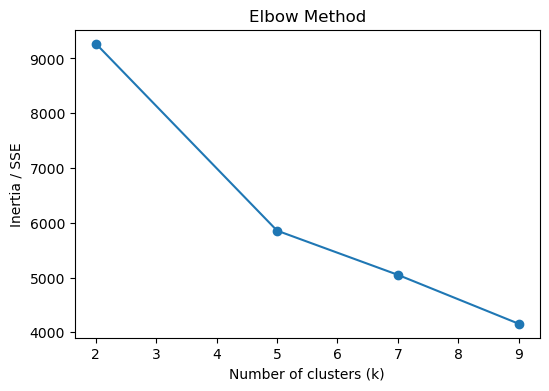

In [19]:
plt.figure(figsize=(6,4))
plt.plot(Ks, inertia_list, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia / SSE")
plt.title("Elbow Method")
plt.show()


PLOT SILHOUETTE SCORES

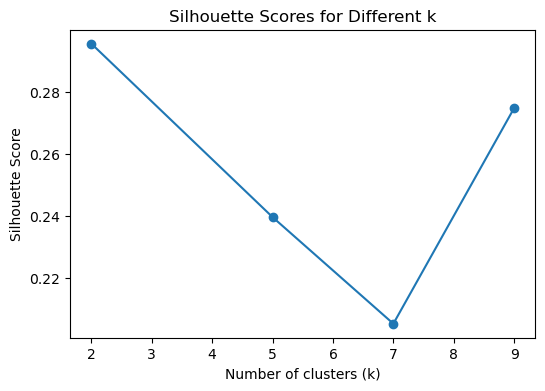

In [21]:
plt.figure(figsize=(6,4))
plt.plot(Ks, silhouette_list, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.show()


VISUALIZE FINAL CLUSTERS

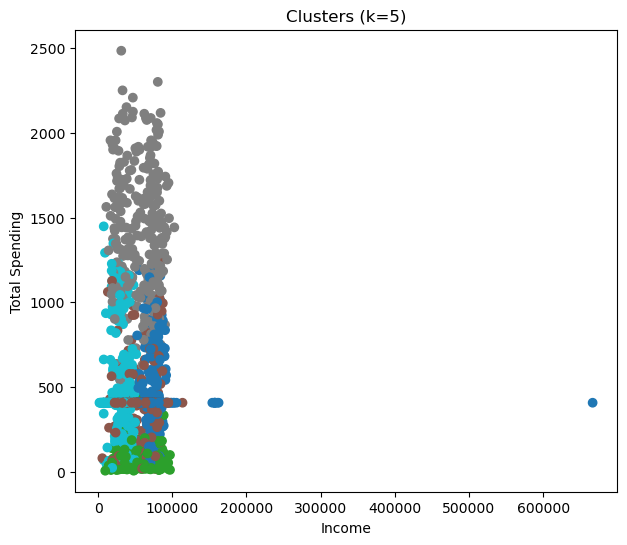

In [22]:
best_k = 5
kmeans = KMeansScratch(k=best_k)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(X['Income'], X['TotalSpend'], c=labels, cmap='tab10')
plt.xlabel("Income")
plt.ylabel("Total Spending")
plt.title(f"Clusters (k={best_k})")
plt.show()


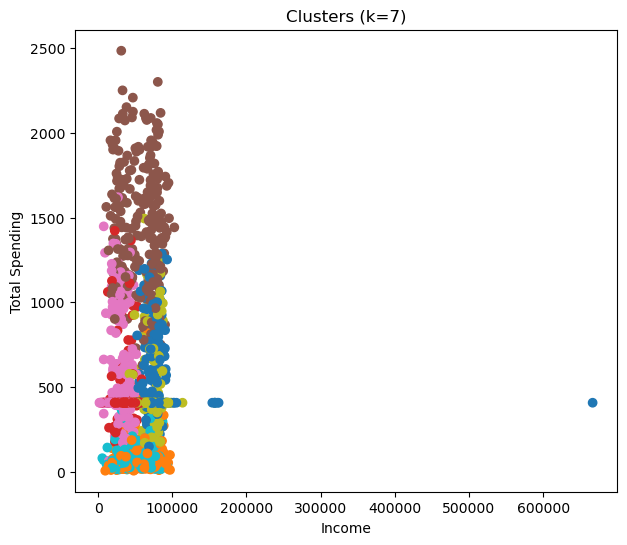

In [23]:
best_k = 7
kmeans = KMeansScratch(k=best_k)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(X['Income'], X['TotalSpend'], c=labels, cmap='tab10')
plt.xlabel("Income")
plt.ylabel("Total Spending")
plt.title(f"Clusters (k={best_k})")
plt.show()